<p style="color:darkred; font-family:Futura; font-size:50px; text-align:center">WaiDatathon 2021 </p>   

Warning: This is a work in progress

# Content

1. #### [Problem description](#prob)
1. #### [Setup](#setup)
1. #### [Acceptability vs experience of domestic violence](#acc_vs_exp)
1. #### [Analysis of the DHS women questionnaireAnalysis of the DHS women questionnaire](#DHS)
    1. #### [Feature selection](#feat)
    1. #### [Data cleaning](#clean)
    1. #### [Exploratory data analysis](#EDA)
1. #### [Modeling](#model)
    1. #### [Single variable model](#model)
    1. #### [Multivariate model](#model)

<a id="prob"></a>
<p style="color:darkred; font-family:Futura; font-size:40px">1. Problem description</p>

The WaiDatathon 2021 was organized by Women in AI on the theme ["Combat Domestic Violence with Data & AI"](https://www.womeninai.co/waidatathon-details). This notebook reproduces our main analysis. 

Many professionals including social workers, medical professionals, academics, politicians or police agents are working daily to help women in abusive relationships, raise awareness in the general public and overall fight this phenomenon. Despite their efforts domestic violence is still a critical but hidden problem all around the world. When approaching this challenge it was clear for us that no amount of machine learning would solve the problem. Domestic violence is a sensitive and emotional topic for the victims. One of machine learning greatest strength is its ability to automate complex tasks, but domestic violence is a deeply human problem, and we believe that humans are the most important part of the support mechanism. 

There are three human parties involved in domestic violence: the victim, the abuser and the supporters. We approached the challenge in two parts. Firstly, we addressed the victim's point of view. In particular, we tried to understand the relationships between the attitudes toward domestic and its occurence, and how these are affected by demographic characteristics. Secondly, we tried to provide an additional tools to supporters in order to detect women in danger. For this purpose we proposed a machine learning model that creates a questionnaire to detect early signs of domestic violence. Because the model can be deployed on paper or by dialogue, it is especially suited for developing countries. 

You can watch our 5-minute competition talk [here](https://lnkd.in/gBupkte).

<a id="prob"></a>
<p style="color:darkred; font-family:Futura; font-size:40px">1. Dataset description</p>

Our analysis is based on the amazing data from [The Demographic and Health Surveys (DHS) Program](https://www.google.com). This DHS program's goal is to collect, analyze and disseminate accurate and representative data on population, health, HIV and nutrition. It has run more than 400 surveys in 90 countries.

The [dataset provided competition](https://data.world/makeovermonday/2020w10/workspace/file?filename=20200306+Data+International+Women%27s+Day+Viz5+Launch.csv) contains the results to the **acceptability question** (see below) aggregated per demographics (e.g. age, education, location). In other terms, this dataset contains information such as "70% of respondents with a secondary level of education answered 'yes' to a given question". However, since it does not contain the demographic information and answers of individual respondents it was not possible to cross mutliple information (e.g. age and education) or to build a predictive model. 

To overcome this difficulty we obtained the complete DHS survey's [women's questionnaire](https://dhsprogram.com/Methodology/Survey-Types/DHS-Questionnaires.cfm#CP_JUMP_16179) for Sub-Saharan countries. This dataset contains the response of individual respondents (samples) to thousands of questions (features). For a given country and a given survey phase the dataset would contain in the order of 10,000 samples and 4200 features. However, due to time constraints and the necessity to clean the data we did not use all the features but selected a subset of 38 questions.

For the competition we used data of the DHS survey for Benin and Congo, but to comply with copyright requirements of the DHS program only the example data of the DHS survey or generated by [STATcompiler](https://www.statcompiler.com/) are contained in this github repository. Access to more data is free upon request on the [DHS website](https://dhsprogram.com/data/Using-Datasets-for-Analysis.cfm). This notebook can be used to treat any survey data from the DHS women's questionnaire. However, since the survey questions are revised from one phase to another, some adjustements might be required in the data cleaning process when using earlier phases.

Some of the most important features for our analysis were in the form of multiple short questions on a given theme. We treated these questions either as: 
- individual features
- a sum of positive answer (for a given theme)
- a boolean value (True if any question on a theme was answered true, False otherwise)

Below, we list these questions with their possible answers.

# Important questions

### Acceptability of violence:

Feature names: `v744a - v744f` <br>
Possible answers: 
- 0  No
- 1  Yes
- 8  Don't know
- (m) 9  Missing
- (na)    Not applicable

In your opinion, is a husband justified in hitting or beating his wife when:
- she goes out without telling him?
- she neglects the children?
- she argues with him?
- she refuses to have sex with him?

### marital control behaviors:
Feature name: `d101a - d101e` <br>
Possible answers: see previous  <br>

Does your husband: 
- become jealous or angry if you talks to other men?
- frequently accuses you of being unfaithful?
- not permit you to meet your female friends?
- tries to limit your contact with your family?
- insists on knowing where you are at all times?
- not trust you with money?





### Physical violence:

Feature names: `d105a - d105k` <br>
Possible answers: <br>
- 0  Never
- 1  Often
- 2  Sometimes
- 3  Yes, but not in the last 12 months
- 4  Yes, but frequency in last 12 months missing
- (m) 9  Missing
- (na)    Not applicable

Have you even been:
- pushed, shook or had something thrown by husband/partner?
- slapped by husband/partner?
- punched with fist or hit by something harmful by husband/partner?
- kicked or dragged by husband/partner?
- strangled or burnt by husband/partner?
- threatened with knife/gun or other weapon by husband/partner?
- physically forced into unwanted sex by husband/partner?
- forced into other unwanted sexual acts by husband/partner?
- had arm twisted or hair pulled by husband/partner?
- physically forced to perform sexual acts respondent didn't want to?

### Emotional violence:

Feature names: `d103a - d103c` <br>
Possible answers: see previous <br>

Have you ever benn:
- humiliated by husband/partner?
- threatened with harm by husband/partner?
- insulted or made to feel bad by husband/partner?

<a id="acc_vs_exp"></a>
<p style="color:darkred; font-family:Futura; font-size:40px">2. Setup</p>
First we import libraries, customize figure output and load the data.

In [9]:
# Import libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Customize figure output
plt.style.use('seaborn')
mpl.rc('font', size=18)
mpl.rc('axes', labelsize='large')
mpl.rc('xtick', labelsize='large')
mpl.rc('ytick', labelsize='large')

plt.rcParams['figure.figsize'] = [20, 10] # For larger plots



<a id="acc_vs_exp"></a>
<p style="color:darkred; font-family:Futura; font-size:40px">3. Acceptability vs experience of domestic violence</p>

In [250]:
# df = pd.read_csv('./Data/acceptability_vs_experienced_coord.csv')
df = pd.read_csv('./Data/DHS_summary_world.csv', skiprows=1, skipfooter=11)
df = df.merge(pd.read_csv('./Data/iso_alpha_list.csv'),
              left_on='Country', right_on='country',how='left')
# Sample only the most recent survey for each country
country_list = df['Country'].unique().tolist()
temp = [df[df['Country']==country].reset_index().iloc[0] for country in country_list]
df = pd.DataFrame(temp).reset_index().drop(columns=['level_0','index'])

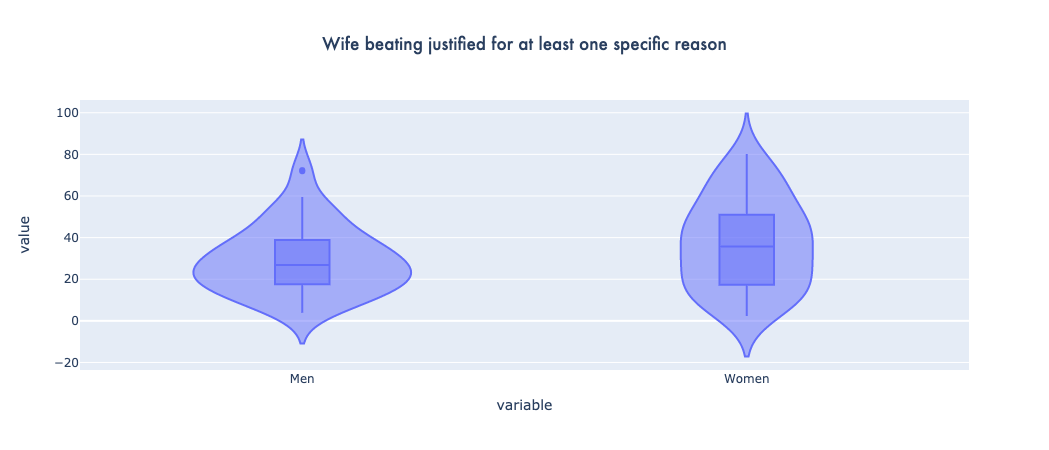

In [389]:
# Distributions
x = "Wife beating justified for at least one specific reason"
y = "Physical violence committed by husband/partner in last 12 months"

y_list = [x + " [Men]", x + " [Women]"]

temp = df[y_list].copy().rename(dict(zip(y_list,["Men", "Women"])),axis=1)
fig = px.violin(temp,box=True,title=x)
fig.update_layout(title=dict(x=0.5,font=dict(family='Futura')))
fig.show()

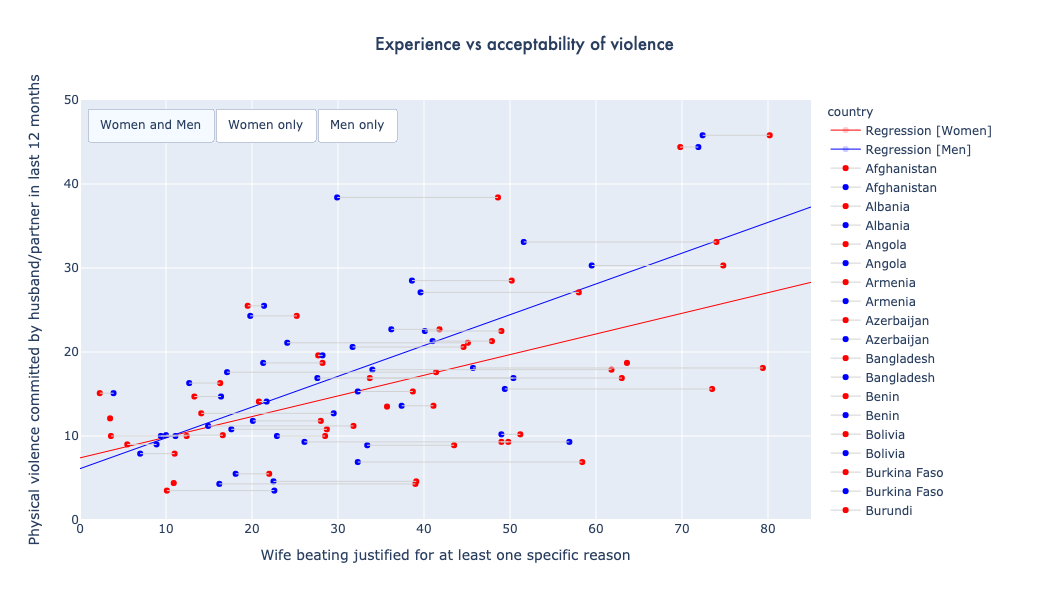

In [523]:
# Scatter plot of  xperience vs acceptability of violence
from sklearn.linear_model import LinearRegression

# Data selection
x = "Wife beating justified for at least one specific reason"
y = "Physical violence committed by husband/partner in last 12 months"
colors = ['red','blue']

# Figure layout
fig = go.Figure(layout=dict(height=600,
                           xaxis=dict( title=x),
                           yaxis=dict( title=y),
                           legend=dict( title='country'),
                           title='Experience vs acceptability of violence'))
xlim = np.array([0,85])
ylim = np.array([0,50])
trace_flag = [] # flagging info for visualization: 0 for women, 1 for men, 2 for both

# Compute and plot regression lines
model = LinearRegression()
for i, gender in enumerate([" [Women]", " [Men]"]):
    df_fit = df[[x + gender, y]].dropna()
    X = df_fit[x + gender].values.reshape(-1, 1)
    model.fit(X, df_fit[y])

    x_range = xlim
    y_range = model.predict(x_range.reshape(-1, 1))    
    fig.add_traces(go.Scatter(x=x_range, y=y_range, 
                              name='Regression' + gender, 
                              line=dict(color=colors[i],width=1),
                              marker=dict(opacity=0)),
                              )  
    trace_flag.append(i)
    
# Plot points for Women, Men and 
for i in range(df.shape[0]): # loop over countries
    fig.add_trace(go.Scatter(x=df[[x + " [Women]"]].iloc[i], 
                            y=[df[y].iloc[i]], 
                            marker=dict(color=['Red']),
                             line=dict(color='rgb(210,210,210)',width=1),
                            name=df['Country'].iloc[i],
                            ))
    trace_flag.append(0)
    
    fig.add_trace(go.Scatter(x=df[[x + " [Men]"]].iloc[i], 
                            y=[df[y].iloc[i]],
                            marker=dict(color='Blue'),
                            line=dict(color='rgb(210,210,210)',width=1),
                            name=df['Country'].iloc[i],
                            ))
    trace_flag.append(1)

# Plot a line that connects men and women for a given country    
for i in range(df.shape[0]):
    fig.add_trace(go.Scatter(x=df[[x + " [Men]", x + " [Women]"]].iloc[i], 
                      y=[df[y].iloc[i],df[y].iloc[i]],
#                              color_discrete_sequence=['red'],
                         line=dict(color='rgb(210,210,210)',width=1),
                        marker=dict(size=0,color='black',opacity=0),
                        name=df['Country'].iloc[i],
                        )) 
    trace_flag.append(2)
trace_flag = np.array(trace_flag)
    
# Update title, and axes range
fig.update_layout(title=dict(x=0.5,font=dict(family='Futura')))    
fig.update_xaxes(range=xlim)
fig.update_yaxes(range=ylim)

# GUI
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            active=0,
            xanchor='left',
            x=0.01,
            yanchor='top',
            y=0.98,
            buttons=list([
                dict(label="Women and Men",
                     method="restyle",
                     args = [{'visible': np.ones(len(trace_flag))}],
                    ),
                dict(label="Women only",
                     method="restyle",
                     args = [{'visible': trace_flag==0}]
                    ),
                dict(label="Men only",
                     method="restyle",
                     args=[{'visible': trace_flag==1}]),
            ])
        )
    ]
)


fig.show()

There seems to be a certain correlation between acceptability and experience of violence although the data are quite scattered. The regression line tells us that on average, for every 10% acceptability, domestic violence increases by ~2% (women acceptability) and 4% (men acceptability). In most countries the acceptability score is much higher than the experience score which indicates either that even woman who don't experience domestic violence find it acceptable or that domestic violence is largely unreported. 


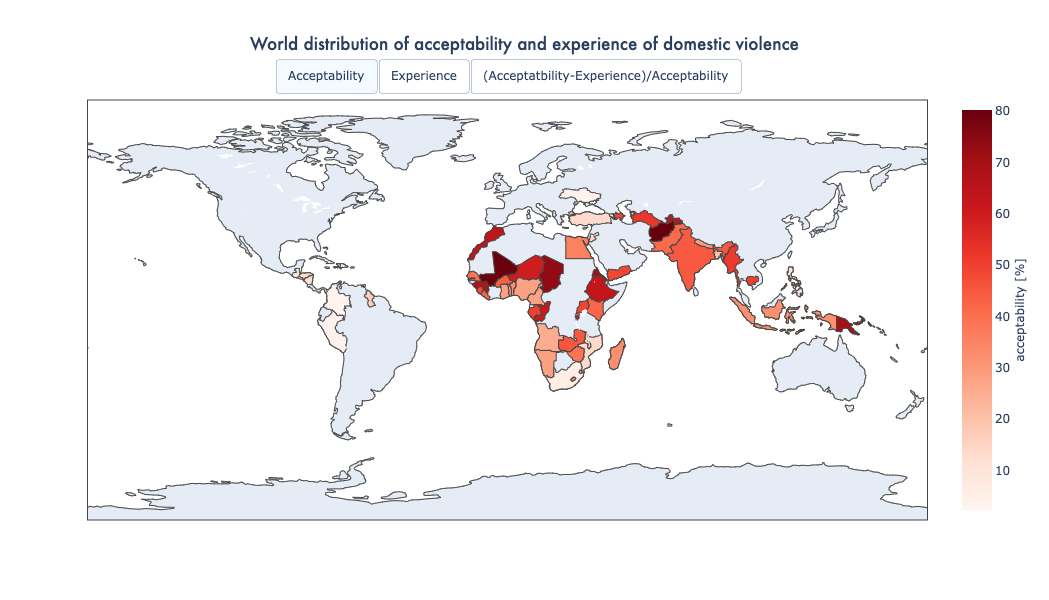

In [518]:
# create figure
acc = "Wife beating justified for at least one specific reason" + " [Women]"
exp = "Physical violence committed by husband/partner in last 12 months"

fig = go.Figure(layout=dict(width=1000,height=600))
hover_text = 'country: ' + df['country'] + "<br>" + \
              'experience: ' + df[exp].astype(str) + ' %<br>' + \
              'acceptability: ' + df[acc].astype(str) + ' %<br>'

# Add surface trace
fig.add_trace(go.Choropleth(z=(df[acc]-df[exp])/df[acc].values.tolist(),
                            locations=df['iso_code'].values.tolist(),
                            text=hover_text, hoverinfosrc='text',
                            visible=False,
                            zmin=-1.0,
                            zmax=1.0,
                            colorscale='PiYG_r',
                            colorbar=dict(title=dict(text='(acc-exp)/acc []',side='right'))
                           ))

fig.add_trace(go.Choropleth(z=df[exp].values.tolist(),
                            locations=df['iso_code'].values.tolist(), 
                            text=hover_text, hoverinfosrc='text',
                            colorscale="Greens",
                            visible=False,
                            colorbar=dict(title=dict(text='experience [%]',side='right'))
                           ))

fig.add_trace(go.Choropleth(z=df[acc].values.tolist(),
                            locations=df['iso_code'].values.tolist(), 
                            text=hover_text, hoverinfosrc='text',
                            colorscale="Reds",
                            colorbar=dict(title=dict(text='acceptability [%]',side='right'))
                           ))

fig.update_layout(title=dict(x=0.5, 
                             text='World distribution of acceptability and experience of domestic violence',
                             font=dict(family='Futura')))


fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            active=0,
            xanchor='center',
            yanchor='bottom',
            x=0.5,
            y=1.02,
            buttons=list([
                dict(label="Acceptability",
                     method="restyle",
                     args = [{'visible': [False, False, True]}]
                    ),
                dict(label="Experience",
                     method="restyle",
                     args=[{'visible': [False, True, False]}]),
                dict(label="(Acceptatbility-Experience)/Acceptability",
                     method="restyle",
                     args = [{'visible': [True, False, False]}]),
                    
            ]),
        showactive=True,)
    ])
fig.show()

The above figure shows the distribution of acceptability and experience of violence among women. Here, violence is considered as "acceptable" for the respondent if she answered any of the acceptability question positively. Here, the experience of violence corresponds to any positive answer (answer other than "never") to any of the physical violence question. The dataset was generated using [STATcompiler](https://www.statcompiler.com/).

Acceptability is calculated as the percentage of women who answered "True" to at least one of the acceptability question. While experience counts the percentage of women who answer "yes, in the last twelve" to at least one of the physical violence question.
The (normalized) difference map is computed as $(acceptability-experience)/acceptability$.

Both acceptability and experience are highest in Afghanistan. Acceptability is highest in subsaharan african countries, middle east and south/southeast Asia, and lowest in Europe and Latin America. Experience is above 10% in most countries and highest in Papua New Guinea and Afghanistan. The difference map shows, in green, countries where acceptability is lower experience than experience. This situation may be seen as a good thing if we consider that public awareness may drive a change in society as suggested by the fact that these countries have relatively lower experience percentage points. In countries colored purple experience is higher than acceptability. These countries tend to have relatively high experience scores. Angola has a score close to 0, due to a relatively low acceptability but high experience. Could this low acceptability score signal that a change is about to come in Angola?

The numbers shown here, and especially the experience score must be taken as lower bounds since domestic violence is most likely under-reported.

<a id="DHS"></a>
<p style="color:darkred; font-family:Futura; font-size:40px">4. Analysis of the DHS women questionnaire</p>

<a id="feat"></a>
# 1. Feature selection 

In [11]:
# Load data
df_IR = pd.read_stata("./Data/ZZIR62FL.DTA", convert_categoricals=False)
df_IR.shape

(8348, 4275)

Then, let's define a subset of features to use

In [12]:
# Subset of features
# background

edu = 'v106'
violence_justified = 'v744' # a-e
age = 'v012'
age_group = 'v013'
litteracy = 'v155'
media_paper = 'v157'
media_radio = 'v158'
media_tv = 'v159'
sample_weight = 'v005' # must be divided by 1e6
ever_married = 'v020'
# residence = 'v025'
time2water = 'v115'

has_elec = 'v119'
has_radio = 'v120'
has_tv = 'v121'

has_fridge='v122'
has_bicycle = 'v123'
has_moto = 'v124'
has_car = 'v125'
religion = 'v130'
ethnicity = 'v131'
place_of_residence = 'v134'
edu_attainment = 'v149'
relation2household_head='v150'
sex_household_head = 'v151'
age_household_head = 'v152'

has_phone_landline='v153'
has_phone_mobile='v169a'
use_internet = 'v171a'
use_internet_last_month = 'v171b'
wealth_index = 'v191'

total_child_born = 'v201'
num_sons_died = 'v206'
num_daughters_died = 'v207'
num_dead_child = 'num_dead_child'
num_living_child = 'v218'


selected_for_dom_violence_interview = 'v044'

husband_edu_level = 'v701'# 's904'
husband_occupation = 's908a'
resp_occupation = 's913a'

# Domestic violence
is_currently_in_union= 'v502'
weight_dom_violence = 'd005'
control_issues = 'd101' #a-j
num_control_issues = 'd102'
emotional_violence = "d103" # a-f
emotional_violence_any = 'emotional_violence_any' #'d104'
physical_violence = 'd105' # a-n detailed acts of violence
physical_violence_less_severe = 'd106'
physical_violence_severe = 'd107'
sexual_violence = 'd108'

violence = 'violence'
# any_violence = 'd105' or 'd106' or 'd107'

violence_to_husband ='d112'
partner_drinks_alcohol='d113'
partner_drinks_alcohol_freq = 'd114'
sought_help = 'd119' # a to xk; y=no one
mother_beaten = 'd121'


edu_w = 'v106' # education level women, value =0-3
edu_m = 'mv106' # education level men, 
#Age (v012) is recorded in
#completed years, and is typically reported in 5-year groups (v013). 
# age_group_w = "v013"
# Info for men is in the Men's individual recode (MR) dataset



list_col0 = ['caseid', 'v000', sample_weight,
            edu, age, age_group, litteracy,
            media_paper, media_radio, media_tv,
            ever_married, 
            has_elec, has_radio, has_tv, has_fridge, has_bicycle, has_car, has_moto, 
            has_phone_landline, 
#             has_phone_mobile,
            religion, ethnicity,
            place_of_residence, age_household_head,
            relation2household_head,
            wealth_index,
            total_child_born, num_living_child, 
            
            husband_edu_level,
#             husband_occupation, resp_occupation,
            
            
            selected_for_dom_violence_interview, weight_dom_violence,
            is_currently_in_union, num_control_issues, #emotional_violence_any, 
            physical_violence_less_severe, physical_violence_severe, sexual_violence,
            partner_drinks_alcohol, partner_drinks_alcohol_freq, #sought_help,
            mother_beaten
           ]
len(list_col0)


38

<a id="clean"></a>
# 2. Data cleaning

In [4]:
# Prepare clean format for multiple questions

# Violence_justified
# =======
'''
V744A                  Beating justified if wife goes out without tell 6103    1    N    I    1    0   No   No
                               0  No
                               1  Yes
                               8  Don't know
                           (m) 9  Missing
                          (na)    Not applicable
'''
# I assume 0 if v744 in [0, 8, 9, na]; 1 otherwise


# Control issues
# =======
'''
D101A                  Husband/partner jealous if respondent talks wit 8272    1    N    I    1    0   No   No
                               0  No
                               1  Yes
                               8  Don't know
                           (m) 9  Missing
                          (na)    Not applicable
'''
# For cleaning: same as previous

# Physical or sexual violence
# =======
'''
D105A                  Ever been pushed, shook or had something thrown 8291    1    N    I    1    0   No   No
                               0  Never
                               1  Often
                               2  Sometimes
                               3  Yes, but not in the last 12 months
                               4  Yes, but frequency in last 12 months missing
                           (m) 9  Missing
                          (na)    Not applicable
'''
# Let's consider true if hit during the past 12 months only
# So, we clean as 0 if d105a in [0, 2,3,4,9,na]


# Emotional violence
# =======
'''
D103A                  Ever been humiliated by husband/partner         8284    1    N    I    1    0   No   No
                               0  Never
                               1  Often
                               2  Sometimes
                               3  Yes, but not in the last 12 months
                               4  Yes, but frequency in last 12 months missing
                           (m) 9  Missing
                          (na)    Not applicable
'''
# Same as physicial violence for cleaning



cleaning_dict = {
     violence_justified: {'num_questions': 5, 'values_0': [8,9]},
     control_issues:     {'num_questions': 10, 'values_0': [8,9]},
     physical_violence:  {'num_questions': 14, 'values_0': [2,3,4,9]},
     emotional_violence: {'num_questions': 6, 'values_0': [2,3,4,9]},
     }
        

In [5]:
# Add multiple questions to list_col
list_col = list_col0.copy()
for key in cleaning_dict.keys():
    cleaning_dict[key]['list_col'] = [key + letter for letter in 'abcdefghijklmnopqrstuvwxyz'[:cleaning_dict[key]['num_questions']]]
    list_col += cleaning_dict[key]['list_col']

In [6]:
# Create a subset dataframe that contains only the chosen columns 
# and only for women who are married and took the domestic violence interview
df = df_IR[list_col].copy()
df = df[df[is_currently_in_union]==1]
df = df[df[selected_for_dom_violence_interview]==1]
df.shape

(2017, 73)

In [8]:
for key in cleaning_dict.keys():
    df[key + '_sum'] = 0
    for letter in 'abcdefghijklmnopqrstuvwxyz'[:cleaning_dict[key]['num_questions']]:
        df[key + letter].fillna(0, inplace=True) # There shouldn't be missing na because of preselection of samples, but just in case
        for i in cleaning_dict[key]['values_0']:
            df.loc[df[key +  letter] == i,key + letter] = 0
        df[key + '_sum'] += df[key +  letter]
        
        # Check that assignment is correct
        assert df[key + letter].max() <= 1
#         print(key + letter + ":", df[key + letter].max())

In [9]:
# Feature engineering
df[num_dead_child] = df[total_child_born] - df[num_living_child]

In [10]:
# Weighting features
# df[violence_justified + '_weighted'] = df[violence_justified]*df[sample_weight]/1e6
# df[violence + '_weighted'] = df[violence]*df[sample_weight]/1e6



<a id="EDA"></a>
# 3. Exploratory data analysis

d105_sum,0.0,1.0
v744_sum,,
0.0,669,36
1.0,1236,76


<AxesSubplot:title={'center':'Number of respondents for each class of score (only respondent experiencing domestic violence)'}, xlabel='v744_sum', ylabel='1.0'>

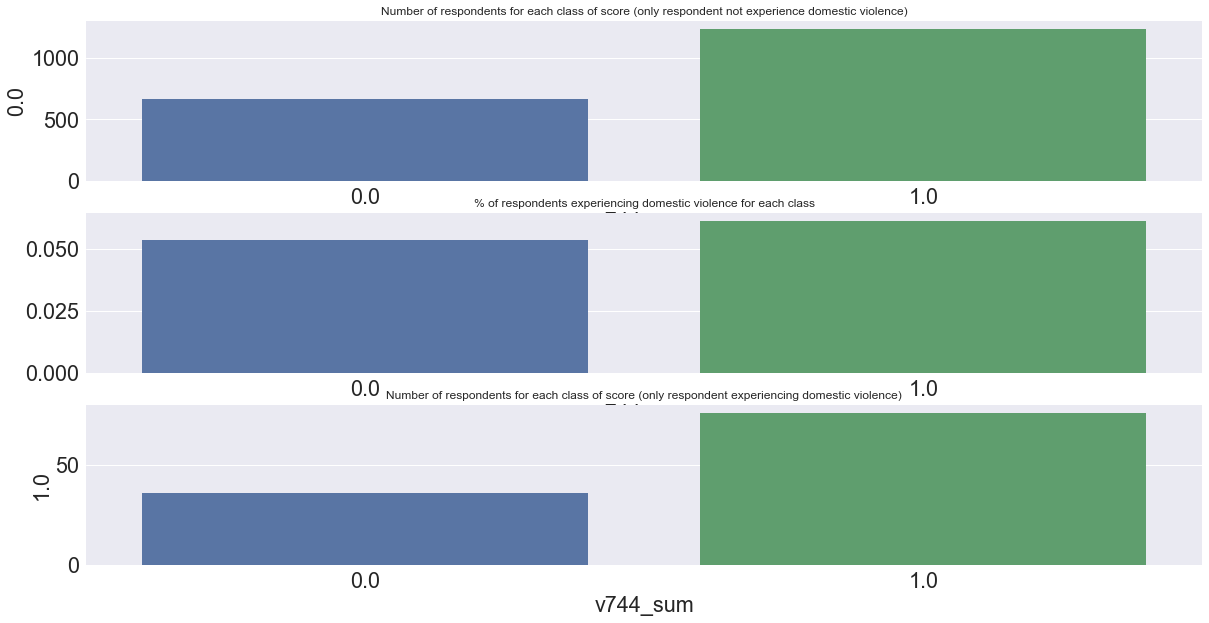

In [11]:
temp = df[[violence_justified + '_sum', physical_violence + '_sum']].copy()
temp['value'] = 1
temp.loc[temp[physical_violence + '_sum']>=1, physical_violence + '_sum']=1
temp.loc[temp[violence_justified + '_sum']>=1, violence_justified + '_sum']=1
temp_pivot = temp.pivot_table(columns=[physical_violence + '_sum'],
                              index=[violence_justified + '_sum'],
                              values='value',aggfunc='count')
display(temp_pivot)

plt.subplot(311)
plt.title('Number of respondents for each class of score (only respondent not experience domestic violence)')
sns.barplot(x=temp_pivot.index, y=temp_pivot.loc[:,0])
plt.subplot(312)
plt.title('% of respondents experiencing domestic violence for each class')
sns.barplot(x=temp_pivot.index, y=temp_pivot.loc[:,1]/temp_pivot.loc[:,0])
plt.subplot(313)
plt.title('Number of respondents for each class of score (only respondent experiencing domestic violence)')
sns.barplot(x=temp_pivot.index, y=temp_pivot.loc[:,1])


- subplot(1) most respondents answered no to every question (ie v744_sum == 0)
- subplot(2) Given the v744 score, the probability to experience violence is higher for higher scores (i.e., P(A|B), where A is score and B is violence)
- subplot(3) since there are many more people with a score of 0, most people experiencing violence scored 0 (i.e. P(B|A))

The results from subplot 2 and 3, are typical examples of bayesian probability.


<AxesSubplot:xlabel='d105_sum', ylabel='v744_sum'>

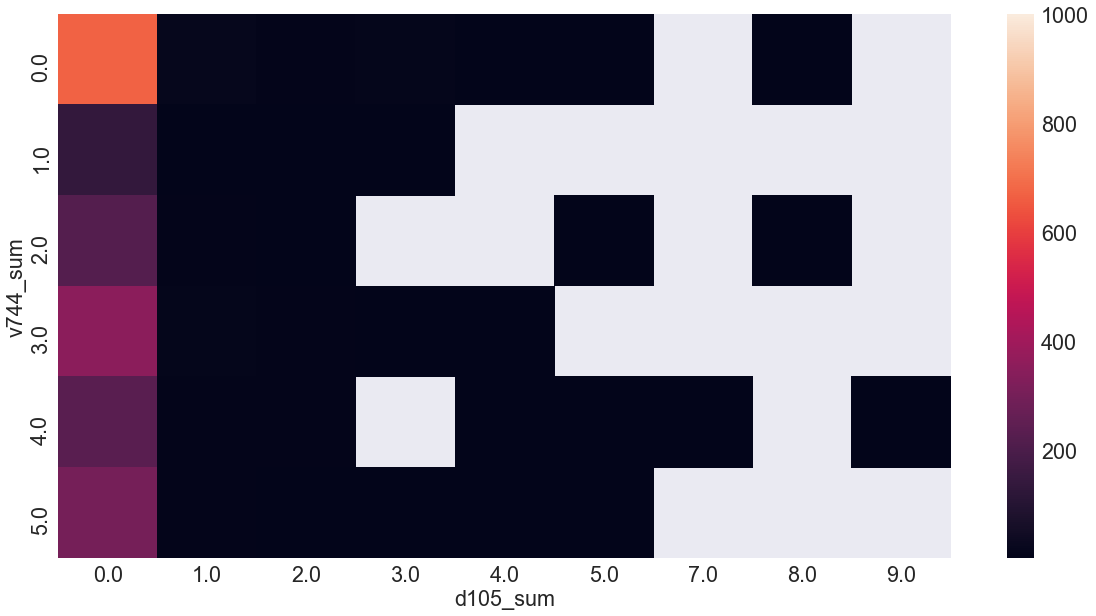

In [12]:
temp = df[[violence_justified + '_sum', physical_violence + '_sum']].copy()
temp['value'] = 1
# temp.loc[temp[physical_violence + '_sum']>=1, physical_violence + '_sum']=1
# temp.loc[temp[violence_justified + '_sum']>=1, violence_justified + '_sum']=1
temp_pivot = temp.pivot_table(columns=df[physical_violence + '_sum'],
                              index=[violence_justified + '_sum'],
                              values='value',aggfunc='count')

sns.heatmap(temp_pivot,vmax=1000)

### What is the most common form of physical+sexual domestic violence?

In [13]:
key = physical_violence
physical_violence_questions_sum = df[[key + letter for letter in 'abcdefghijklmnopqrstuvwxyz'[:cleaning_dict[key]['num_questions']]]].sum()
num_physical_violence_respondent = (df[physical_violence + '_sum']>0).sum()

<AxesSubplot:>

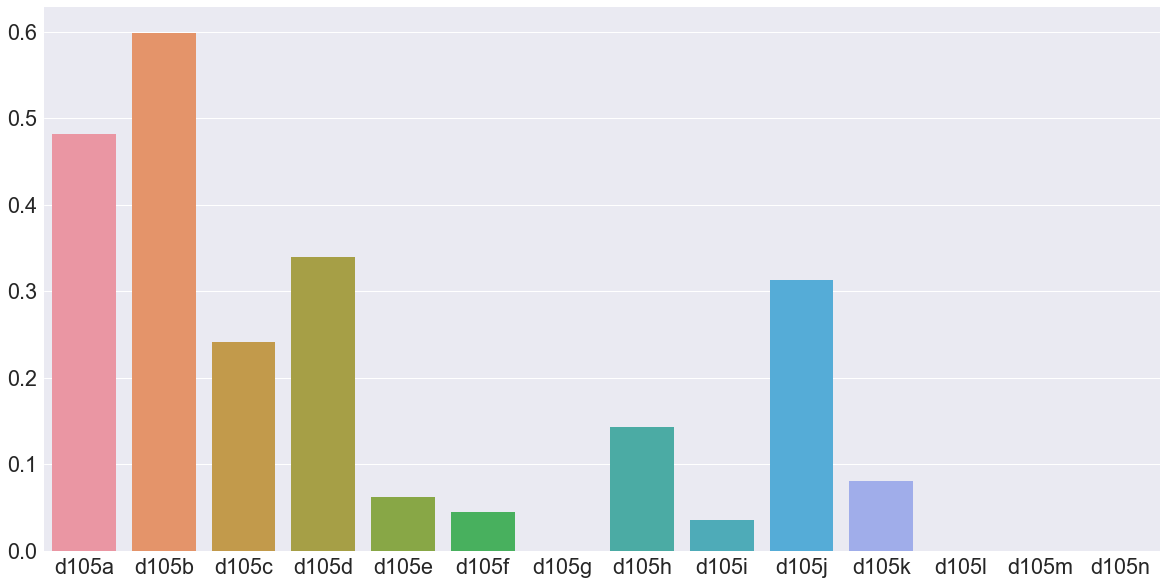

In [14]:
sns.barplot(y=physical_violence_questions_sum/num_physical_violence_respondent, x=physical_violence_questions_sum.index)

### What are forms of violence that occur together?
    
    

In [15]:
list_col_a = cleaning_dict[emotional_violence]['list_col']
list_col_b = cleaning_dict[physical_violence]['list_col']
list_col = list_col_a + list_col_b
temp = df[[emotional_violence + "_sum", physical_violence + "_sum"]].copy()
# temp_phy = df[physical_violence + "_sum"]

temp[emotional_violence + "_sum"] = temp[emotional_violence + "_sum"]>0
temp[physical_violence + "_sum"] = temp[physical_violence + "_sum"]>0

temp.loc[temp[emotional_violence + "_sum"]==1,physical_violence + "_sum"].sum()/temp.shape[0]
# temp.sum()/temp.shape[0]*100
(df[cleaning_dict[physical_violence]['list_col']].sum(axis=1)>0).sum()
# temp[emotional_violence + "_sum"].sum()
# # temp = df[list_col]
# co_occurence = (temp.T@temp)#.values
# for i in range(co_occurence.shape[0]):
#     co_occurence.iloc[i,:] /= co_occurence.iloc[i,i]
    
# sns.heatmap(co_occurence*100,annot=True)
# _ = plt.title("Co-occurence of positive physical or sexual violence acts in the last 12 months")

112

In [16]:
# Select some features for mutual information analysis
# list_col_model = [edu, age, age_group, litteracy,
#             media_paper, media_radio, media_tv,has_elec, has_radio, has_tv, has_fridge, has_bicycle, has_car, has_moto, 
#             has_phone_landline, 
# #             has_phone_mobile,
#             religion, ethnicity,
# #             place_of_residence, 
#             age_household_head,
#             relation2household_head,
#             wealth_index,
#             total_child_born, num_living_child, num_dead_child, 
            
            
#             husband_edu_level, 
# #             num_control_issues,
#             partner_drinks_alcohol, partner_drinks_alcohol_freq,
#             control_issues + '_sum',
#             violence_justified + '_sum',
# #             violence_justified,
#             emotional_violence + '_sum',
# #             emotional_violence_any,
#             physical_violence + '_sum',
            
#             mother_beaten,
# #             husband_occupation, resp_occupation,
#             ]
list_col_model = [
            litteracy,
            age,      
            mother_beaten,
            wealth_index,
            num_living_child,
            edu,      
            husband_edu_level, 
#             partner_drinks_alcohol, 
            partner_drinks_alcohol_freq,
            control_issues + '_sum',
            violence_justified + '_sum',
            emotional_violence + '_sum',
            physical_violence + '_sum',
            ]
X = df[list_col_model].copy()
explicit_feature_names = [
    'Literacy', 
    'Age', 
    'Did your father ever beat your mother', 
    'wealth index', 
    'number of children',
    'Education level', 
    "Husband's education level", 
#     "Does your husband drink alcohol?",
    'How often does your husband drink alcohol?', 
    'Is your husband jealous, or not trusting you with money?',
    'Is a husband justified to beat his wife?',
    'Have you ever been humiliated, insulted or threatened by your husband?',
#     'Physical violence'
    ]


# for key in cleaning_dict.keys():
#     cleaning_dict[key]['list_col'] = [key + letter for letter in 'abcdefghijklmnopqrstuvwxyz'[:cleaning_dict[key]['num_questions']]]
#     list_col += cleaning_dict[key]['list_col']

# X.loc[:,husband_occupation] = X.loc[:,husband_occupation].astype('int8') # /!\ contains "8" as Nan
# X.loc[:,resp_occupation] = X.loc[:,resp_occupation].astype('int8') # /!\ contains "8" as Nan

# replace not applicable by "doesn't drink" for alcohol related question
for col in [partner_drinks_alcohol_freq, mother_beaten]:
# for col in [partner_drinks_alcohol, partner_drinks_alcohol_freq, mother_beaten]:
    X[col].fillna(0, inplace=True)
    


# feature engineering
age_diff = 'age_diff'
age_ratio = 'age_ratio'
# X[age_diff] = X[age] - X[age_household_head]

X.loc[:,'v701'].fillna(0,inplace=True) # only 2 missing values in Congo, 0 in Benin

X.loc[X[litteracy]>=3,litteracy] = 0
X.loc[X[litteracy]<=1,litteracy] = 0
X.loc[X[litteracy]==2,litteracy] = 1


# cast the following columns as int8 to treat them as discrete features
for col in [ partner_drinks_alcohol_freq, mother_beaten, #relation2household_head,
           husband_edu_level]:#, emotional_violence_any]: 
# for col in [partner_drinks_alcohol, partner_drinks_alcohol_freq, mother_beaten, relation2household_head,
#            husband_edu_level]:#, emotional_violence_any]: 
    X.loc[:,col] = X.loc[:,col].astype('int8') # /!\ contains "8" as Nan

    
# cast the following columns a floats continuous features
# for col in [total_child_born, num_living_child, num_dead_child, age, age_household_head, age_diff,
#            violence_justified + '_sum', 
#             emotional_violence + '_sum',
#             physical_violence + '_sum', 
#             control_issues + '_sum',
#             wealth_index]:
for col in [num_living_child, #num_dead_child, total_child_born, 
            age, #age_household_head, age_diff,
            violence_justified + '_sum', 
            emotional_violence + '_sum',
            physical_violence + '_sum', 
            control_issues + '_sum',
            wealth_index]:
    X[col] = X[col].astype(float)


    
discrete_features = X.dtypes == 'int8'
X.dropna(inplace=True)
# X.dropna().info()

In [17]:
# dict(zip(X.columns,explicit_feature_names))
# X.info()

In [27]:
# Mutual information classification
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores



def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores", fontsize=25)


(2011, 12)

In [19]:
# Let's try subsampling the majority class (no violence) to get better classification on the minority class (i.e. the class of interest)
from sklearn.model_selection import train_test_split

def subsample(X,y,imbalance_fac=1):
    y_select = df[physical_violence + "_sum"]>0
    y_negative = y[y_select==0].copzy()
    y_positive = y[y_select==1].copy()
    
    X_negative = X.loc[y_select==0,:].copy()
    X_positive = X.loc[y_select==1,:].copy()
    
#     # duplicate positive cases
#     for i in range(4):
#         y_positive = np.concatenate([y_positive, y_positive])
#         X_positive = np.concatenate([X_positive, X_positive],axis=0)
    
    # subsample negative cases
    _, X_negative_sub, _, y_negative_sub = train_test_split(X_negative,y_negative, test_size=imbalance_fac*len(y_positive))#, stratify=True )
    return (pd.DataFrame(np.concatenate([X_negative_sub,X_positive]), columns=X.columns), 
            pd.Series(np.concatenate([y_negative_sub,y_positive]), ))


# y = df[violence_justified + '_sum']>0
# this_X = X.drop(columns=[violence_justified + "_sum"] )# +cleaning_dict[violence_justified]['list_col'])
# this_X, y = subsample(this_X,y)      
# y.shape

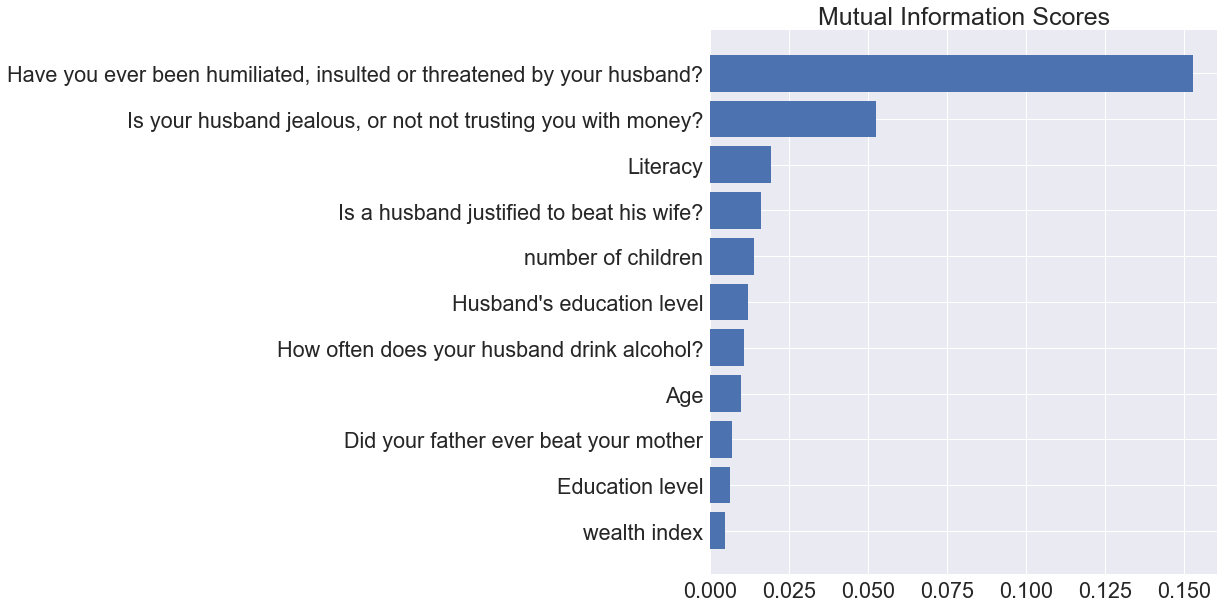

In [20]:
# for itarget, target_feature in enumerate([violence_justified, physical_violence]):
for itarget, target_feature in enumerate([physical_violence]):    
    y = X[target_feature + '_sum']>0
    
    plt.subplot(1,2,itarget+1)
    this_X = X.drop(columns=[target_feature + "_sum"] )
    discrete_features = this_X.dtypes == 'int8'
    mi_scores = pd.Series(np.zeros(this_X.columns.shape), index= this_X.columns)
    n = 20
    for i in range(n):
        X_sub, y_sub = subsample(this_X,y)     
        
        mi_scores += 1.0/n*make_mi_scores(X_sub, y_sub, discrete_features)
        
    mi_scores.rename(dict(zip(X.columns,explicit_feature_names)), inplace=True)
    plot_mi_scores(mi_scores)


In [21]:
# Clean up missing values
# X.info()
for col in X.columns:
    print(col + ": ", X[col].unique())

v155:  [0. 1.]
v012:  [30. 46. 37. 25. 35. 33. 47. 24. 40. 27. 29. 45. 32. 43. 41. 20. 26. 22.
 23. 18. 19. 44. 39. 28. 36. 34. 17. 42. 48. 31. 21. 38. 49. 16. 15.]
d121:  [1 8 0]
v191:  [-128996.   75335.   -6776. ...   45998.  183690.   46408.]
v218:  [ 4.  2.  5.  1.  6.  3.  0.  8.  7.  9. 10.]
v106:  [0 1 2 3]
v701:  [0 2 3 1 8]
d114:  [0 2 1]
d101_sum:  [3. 0. 2. 4. 5. 1.]
v744_sum:  [5. 0. 2. 4. 3. 1.]
d103_sum:  [0. 1. 2. 3.]
d105_sum:  [0. 1. 2. 5. 4. 3. 9. 8. 7.]


# Let's try prediction

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn. ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score
y = X[physical_violence + "_sum"]>0
this_X = X.drop(columns=[physical_violence + "_sum"])
this_X.columns
discrete_features = this_X.dtypes == 'int8'
X_model = pd.get_dummies(this_X, columns=this_X.columns[discrete_features])
imbalance_fac = 1
X_model, y = subsample(X_model,y, imbalance_fac=imbalance_fac)      
X_train, X_test, y_train, y_test = train_test_split(X_model.values,y.values, test_size=0.2)

param_grid = dict(max_depth=[9], 
                  min_samples_leaf=[0.05, 0.07, 0.1, 0.15, 0.2, 0.25, .3, 0.5],
                 )

 
clf = DecisionTreeClassifier(min_impurity_decrease=0.0001,
                             class_weight={0:1, 1:imbalance_fac}, 
                             )

clf_cv = GridSearchCV(clf, param_grid, cv=3, scoring='recall')


clf_cv.fit(X_train, y_train)
display(clf_cv.best_params_)
y_pred = clf_cv.best_estimator_.predict(X_test)

print(confusion_matrix(y_test, y_pred)/y_test.shape[0])
classif_dict = classification_report(y_test,y_pred, output_dict=True)
print("f1_score:", classif_dict['True']['f1-score'])
print(classification_report(y_test,y_pred))

{'max_depth': 9, 'min_samples_leaf': 0.07}

[[0.28888889 0.17777778]
 [0.22222222 0.31111111]]
f1_score: 0.6086956521739131
              precision    recall  f1-score   support

       False       0.57      0.62      0.59        21
        True       0.64      0.58      0.61        24

    accuracy                           0.60        45
   macro avg       0.60      0.60      0.60        45
weighted avg       0.60      0.60      0.60        45



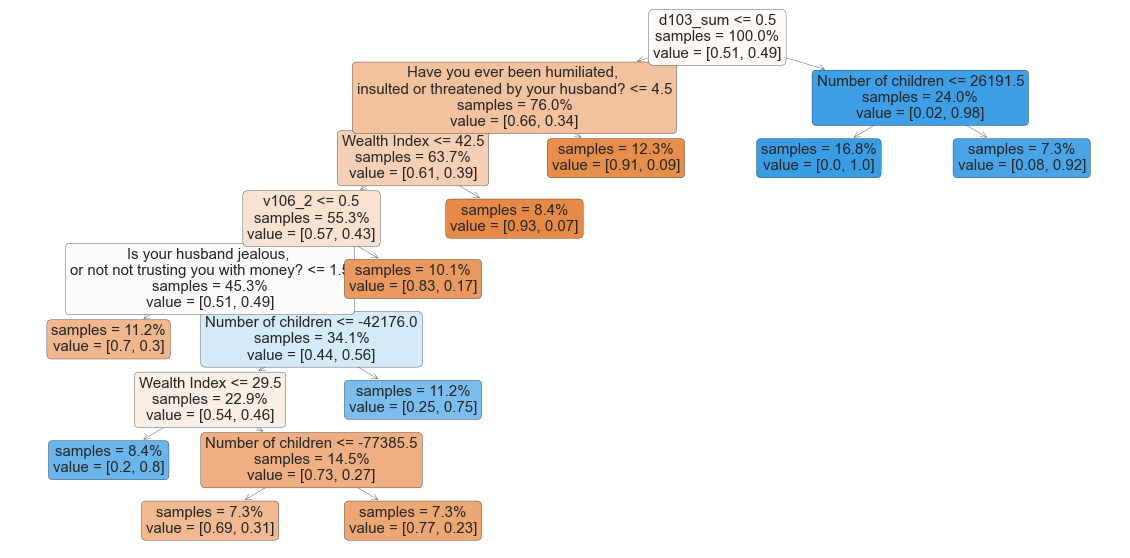

In [23]:
expl_feature_names_model =(list(X_model.columns.copy()))
# expl_feature_names_model.rename({'v012':  '5-year age group'}, inplace=True)

expl_feature_names_model[:6] = [
    '5-year age group', 
    'Wealth Index',
    'Number of children',
    'Is your husband jealous, \nor not trusting you with money?',
    'Is a husband justified to beat his wife?',
    'Have you ever been humiliated, \ninsulted or threatened by your husband?',
]
# fig, ax = plt.subplots(1,1)
# _ = tree.plot_tree(clf_cv.best_estimator_, feature_names=X_model.columns, filled=True, 
#                    impurity=False, proportion=True, precision=2, rounded=True)
_ = tree.plot_tree(clf_cv.best_estimator_, feature_names=expl_feature_names_model, filled=True, 
                   impurity=False, proportion=True, precision=2, rounded=True,fontsize=15)

# _ = tree.plot_tree(clf, feature_names=X_model.columns)

In [24]:
X_model.columns

Index(['v155', 'v012', 'v191', 'v218', 'd101_sum', 'v744_sum', 'd103_sum',
       'd121_0', 'd121_1', 'd121_8', 'v106_0', 'v106_1', 'v106_2', 'v106_3',
       'v701_0', 'v701_1', 'v701_2', 'v701_3', 'v701_8', 'd114_0', 'd114_1',
       'd114_2'],
      dtype='object')

In [25]:

#     'Litteracy',
    
#     'Did your father ever beat your mother', 

    
#     'Education level', 
#     "Husband's education level", 
# #     "Does your husband drink alcohol?",
#     'How often does your husband drink alcohol?', 
    
    
    
# #     'Physical violence'
#     ]

In [26]:
np.sum(np.abs(y_test.values-y_pred))

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
np.sum(y_test.values.astype(int) - y_pred.astype(int))

In [ ]:
cleaning_dict

In [ ]:
# For Ettore
df[cleaning_dict['v744']['list_col'] + cleaning_dict['d105']['list_col'] + cleaning_dict['d103']['list_col']].astype(int).to_csv('data_Ettore.csv')

In [ ]:
mi_benin = mi_scores.copy()

In [ ]:
mi_congo = mi_scores.copy()

In [ ]:
mpl.rc('font', size=30)
fig = plt.figure(figsize=[20,15])
for i, scores in enumerate([mi_benin, mi_congo]):
    width = 2*np.arange(len(scores))
    scores = scores.sort_values(ascending=True)
    plt.barh(-0.8*i+width, scores)



ticks = list(scores.index)


plt.yticks(width, ticks)
plt.title("Mutual Information Scores", fontsize=40)
